In [1]:
import stumpy
import pandas as pd
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


In [2]:
t = yf.Ticker('^GSPC')
series = t.history(start='1930-01-01',period='1d')['Close']
series.head()
series 

Date
1929-12-31      21.450001
1930-01-02      21.180000
1930-01-03      21.230000
1930-01-06      21.500000
1930-01-07      21.309999
                 ...     
2022-07-01    3825.330078
2022-07-05    3831.389893
2022-07-06    3845.080078
2022-07-07    3902.620117
2022-07-08    3899.379883
Name: Close, Length: 23244, dtype: float64

In [26]:
def get_closest_subsequences(series,n=10,m=22):
    '''Gets an array of integers that corresponds to the numerical
    indices of the original series where a close subseuence starts.
    
    Stumpy may give us subsequences that overlap (for example, index 459 and 461)
    so this function changes that by discarding susbsequences where the price 
    may overlap with another.
    
    args:
        series: pandas.Series: The whole series from start to end.
        n: int (optional): The number of closest subsequences the algorithm will extract.
        m: int (optional): The number of data points that constitute the subsequences.
    returns:
        dict: Two keys:
            indices: np.array of indices
            values: The values corresponding to the euclidian distance
            calculated by stumpy
    
    '''
    
    subseq = series.iloc[-m:]  # the last subsequence that we try to match
    seq = series.iloc[:-m]  # the rest of the series
    
    distance_profile = stumpy.mass(subseq,seq) / m
    distance_sorted_ix = np.argsort(distance_profile)

    closest_subsequence_ix = np.zeros(n,dtype=np.int64)
    count = 0
    for ix in distance_sorted_ix:
        is_new_subseq = np.all(np.abs(ix - closest_subsequence_ix) > m)
        if is_new_subseq:
            closest_subsequence_ix[count] = ix
            count += 1
        if count == n:
            break
        
    return dict(indices=closest_subsequence_ix,
                values=distance_profile[closest_subsequence_ix],
                dates=series.index[closest_subsequence_ix])
                

m = 22
n = 5
closest_dict = get_closest_subsequences(series,n,m)
print(closest_dict)

{'indices': array([ 9746, 15524,  2773,  6772, 19846]), 'values': array([0.09569309, 0.09780394, 0.09861468, 0.10529076, 0.1062479 ]), 'dates': DatetimeIndex(['1968-12-31', '1991-11-13', '1941-02-06', '1957-01-31',
               '2009-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)}


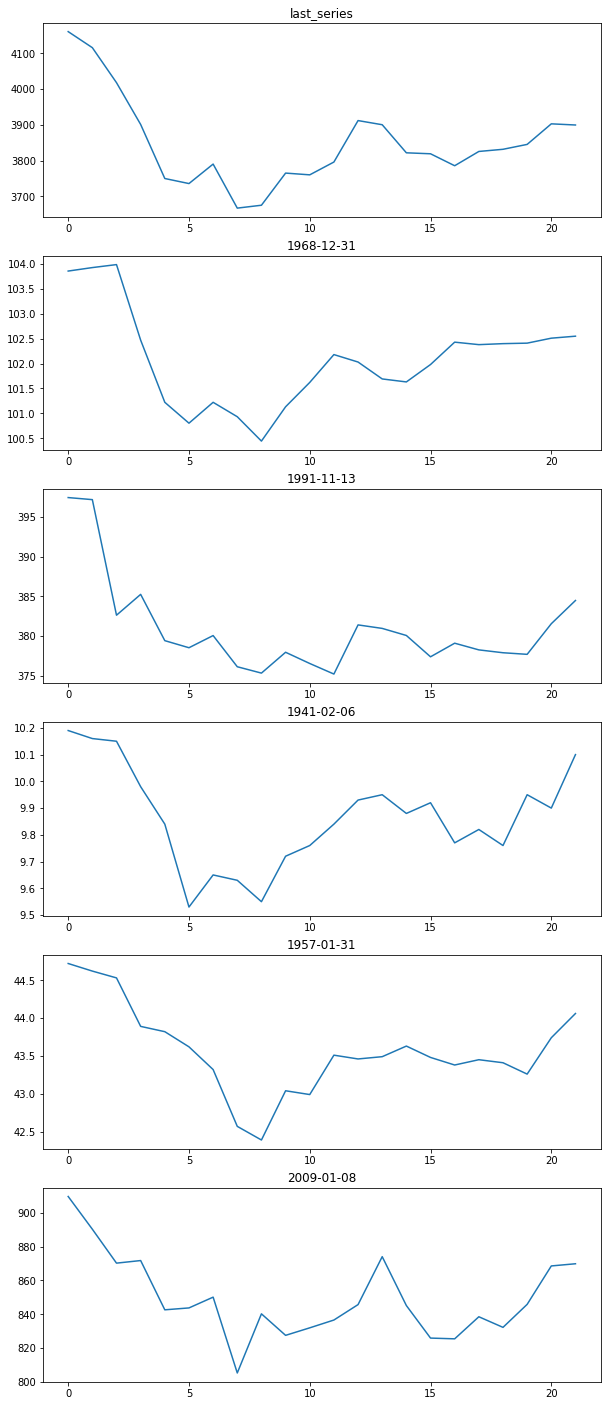

In [28]:
#Let's plot some of it to see
def get_dataframe_with_closest_subsequences(series,indices,m):
    df = pd.DataFrame([])
    last_series = series.iloc[-m:]
    df['last_series'] = last_series.values
    
    for ix in indices:
        data = series.iloc[ix:ix+m].values
        df[series.index[ix].strftime('%Y-%m-%d')] = data
    
    return df

data = get_dataframe_with_closest_subsequences(series,closest_dict['indices'],m)

fig, axes = plt.subplots(nrows=len(data.columns),ncols=1,figsize=(10,25))
for i,col in enumerate(data.columns):
    data[col].plot(ax=axes[i],title=col)



In [31]:
def get_normalized_series(series,indices,m):
    '''Gives back the series normalized using z-scores'''
    df = pd.DataFrame([])
    for i,ix in enumerate(indices):
        data = series.iloc[ix:ix+m].values
        normal_data = (data - data.mean()) / data.std()
        df[f's{i}'] = normal_data
    last_series = series.iloc[-m:]
    df['last_series'] = (last_series - last_series.mean()) / last_series.std()
    return df

def get_closest_subsequence_dates(series,indices):
    return series.iloc[indices].index

df = get_normalized_series(series,closest_dict['indices'],m)
px.line(df)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=s0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 's0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 's0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21]),
              'xaxis': 'x',
              'y': array([ 1.87240619,  1.94611512,  2.00929191,  0.40875171, -0.90748492,
                          -1.34973849, -0.90748492, -1.21285278, -1.72881528, -1.00225813,
                          -0.48628759,  0.10338385, -0.05456615, -0.41257866, -0.47576348,
                          -0.1072108 ,  0.36663117,  0.3139785 ,  0.33504278,  0.34557492,
                           0.45087225,  0.49299278]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=s1<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 's1',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 's1',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21]),
              'xaxis': 'x',
              'y': array([ 2.8489958 ,  2.80404885,  0.29230048,  0.74520957, -0.26086879,
                          -0.4147224 , -0.15023705, -0.82787032, -0.9661666 , -0.51325751,
                          -0.75699975, -0.98690972,  0.08140328,  0.00534165, -0.14850669,
                          -0.61178734, -0.3161873 , -0.46139443, -0.52362907, -0.55819918,
                           0.10733218,  0.61210435]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=s2<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 's2',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 's2',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21]),
              'xaxis': 'x',
              'y': array([ 1.79217489,  1.62789345,  1.57313123,  0.64219439, -0.12445579,
                          -1.82204804, -1.16491707, -1.27443629, -1.7125236 , -0.78158676,
                          -0.5625431 , -0.12445579,  0.36839374,  0.47791296,  0.09458786,
                           0.31363152, -0.50778088, -0.23398023, -0.5625431 ,  0.47791296,
                           0.20410708,  1.29933058]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=s3<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 's3',
              'line': {'color': '#ab63fa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 's3',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21]),
              'xaxis': 'x',
              'y': array([ 2.04288557,  1.86635586,  1.70748248,  0.57771923,  0.4541518 ,
                           0.1010991 , -0.42847658, -1.75241915, -2.07016591, -0.92274632,
                          -1.01100781, -0.09308022, -0.18134171, -0.12837943,  0.11875544,
                          -0.14603577, -0.32255875, -0.19899132, -0.26960321, -0.53439441,
                           0.31293476,  0.

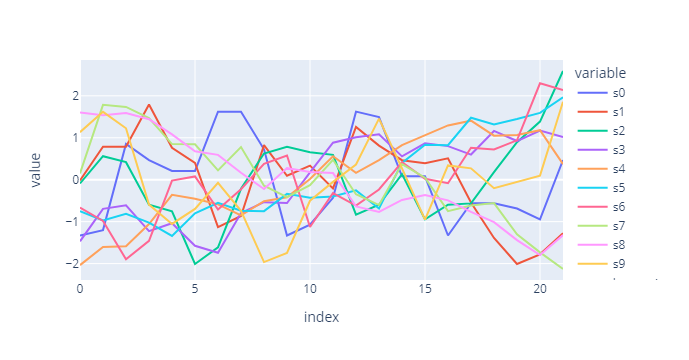

In [72]:
df = get_normalized_series(series,indices,m,60)
px.line(df)

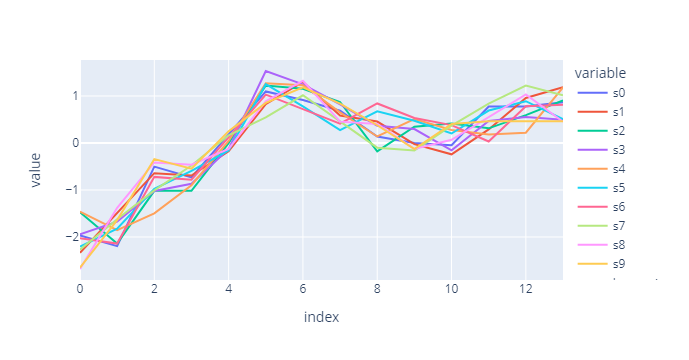

In [13]:
import numpy as np
np.argsort(distance_profile)

array([ 3270, 16022, 10243, ..., 16196,  7372,  8109], dtype=int64)